<a href="https://colab.research.google.com/github/AnnanyaV/kaggle/blob/master/Reliance_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 10.0MB/s 
     |████████████████████████████████| 9.5MB 33.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

In [3]:
df= pd.read_csv('/content/drive/MyDrive/Kaggle Datasets/RELIANCE.csv')

In [4]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [5]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [6]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [7]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2.456000e+03,4.792000e+03,4792.000000
mean,1010.984866,1012.602375,1026.823803,996.886977,1011.157143,1011.316839,1011.937409,5.583028e+06,6.076715e+14,1.452306e+05,2.280885e+06,0.435039
std,570.987079,572.575893,581.986757,560.703328,570.938608,571.046753,571.222520,4.983793e+06,8.369739e+14,1.297557e+05,1.882665e+06,0.144722
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,572.137500,572.925000,582.950000,564.237500,572.062500,572.512500,573.190000,2.836454e+06,2.203354e+14,7.215900e+04,1.194524e+06,0.323325
50%,937.950000,939.000000,950.075000,927.550000,939.025000,938.275000,939.785000,4.213432e+06,3.662999e+14,1.021435e+05,1.810434e+06,0.449450
75%,1247.387500,1247.675000,1267.350000,1227.450000,1248.287500,1248.275000,1247.375000,6.602604e+06,6.656490e+14,1.686702e+05,2.752935e+06,0.544300
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.428490e+06,3.495888e+07,0.978300


In [8]:
df.shape

(5306, 14)

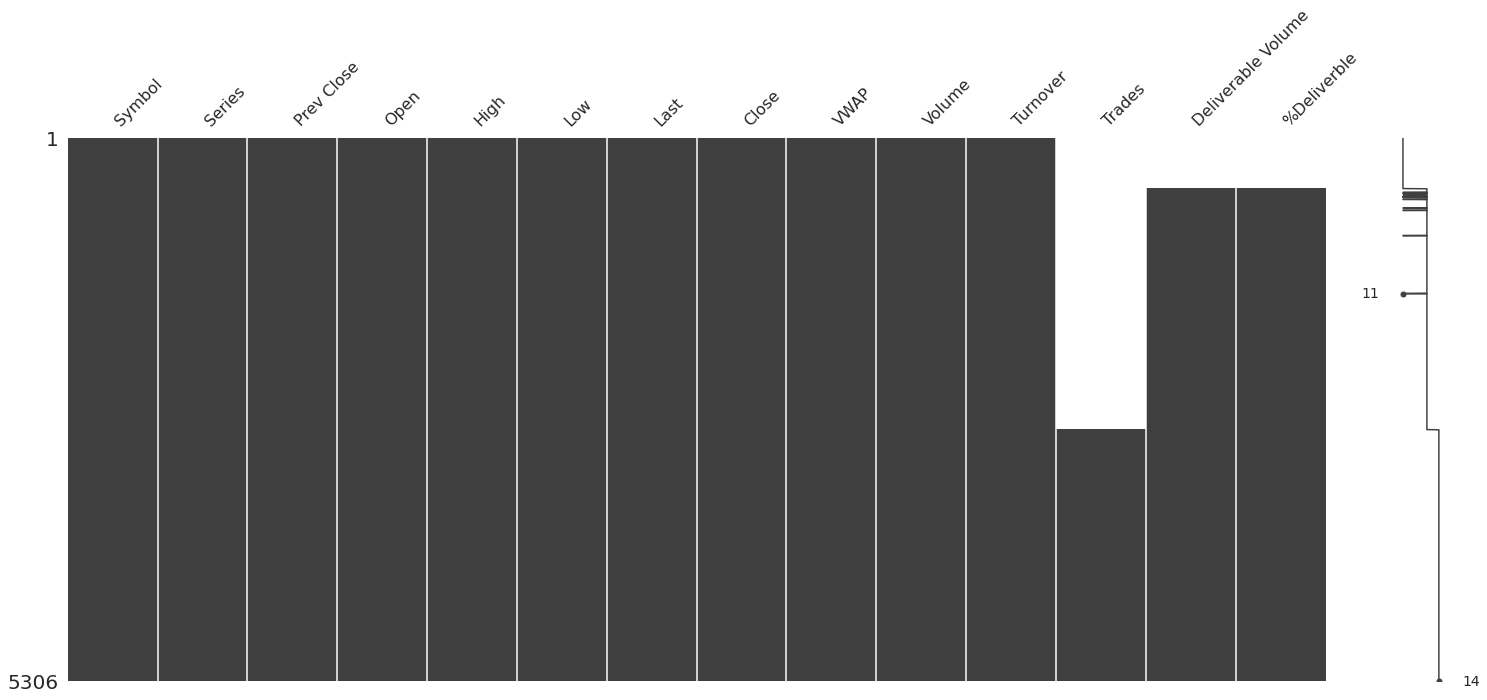

In [10]:
msno.matrix(df)

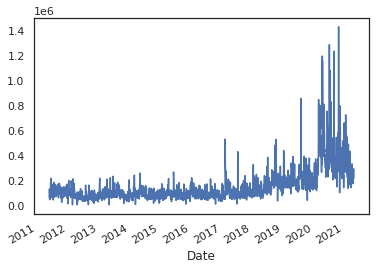

In [11]:
df.Trades.plot()

In [12]:
df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)

In [13]:
fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP over time',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

In [14]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [15]:
dicky_fuller_test(df['VWAP'])

ADF Statistic: -1.837362
p-value: 0.362077
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


In [16]:
df=df.reset_index()

In [17]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14


In [19]:
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [20]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [21]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,1026.299438,1025.654663,1022.002197,14.044213,22.388489,47.826488,996.366943,995.734802,992.128174,14.136286,22.488106,47.708775,5581832.0,5583233.0,5595401.5,1.671438e+06,2045706.25,2583830.50,6.071609e+14,6.066747e+14,6.040751e+14,1.780037e+14,2.185433e+14,2.760155e+14,1010.799927,1010.161926,1006.544128,14.784642,22.771217,47.599812,1,1,3,0
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,251.699997,251.699997,251.699997,14.044213,22.388489,47.826488,237.500000,237.500000,237.500000,14.136286,22.488106,47.708775,4456424.0,4456424.0,4456424.0,1.671438e+06,2045706.25,2583830.50,1.111319e+14,1.111319e+14,1.111319e+14,1.780037e+14,2.185433e+14,2.760155e+14,251.699997,251.699997,251.699997,14.784642,22.771217,47.599812,1,1,4,1
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,244.399994,244.399994,244.399994,9.758074,9.758074,9.758074,6972151.0,6972151.0,6972151.0,3.557775e+06,3557775.25,3557775.25,1.805771e+14,1.805771e+14,1.805771e+14,9.821026e+13,9.821026e+13,9.821026e+13,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,1,1,5,2
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,270.483337,270.483337,270.483337,18.138657,18.138657,18.138657,248.483337,248.483337,248.483337,9.880832,9.880832,9.880832,13592662.0,13592662.0,13592662.0,1.173978e+07,11739778.00,11739778.00,3.661746e+14,3.661746e+14,3.661746e+14,3.288799e+14,3.288799e+14,3.288799e+14,268.683319,268.683319,268.683319,15.642277,15.642277,15.642277,1,1,6,3
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,286.816681,278.037506,278.037506,14.455478,21.156614,21.156614,265.649994,258.612488,258.612488,20.397856,21.805672,21.805672,17334616.0,14115068.0,14115068.0,8.790159e+06,9642262.00,9642262.00,4.835724e+14,3.904623e+14,3.904623e+14,2.443038e+14,2.728875e+14,2.728875e+14,282.899994,275.100006,275.100006,11.255332,18.105661,18.105661,1,1,7,4


In [22]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]

In [23]:
df_valid['Date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                     577
unique                    577
top       2020-04-13 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2021-04-30 00:00:00
Name: Date, dtype: object

In [24]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df_train.VWAP,lags=3, exog=df_train[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.225
Method:               Conditional MLE   S.D. of innovations             29.249
Date:                Thu, 13 May 2021   AIC                              6.768
Time:                        19:34:27   BIC                              6.822
Sample:                             3   HQIC                             6.787
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -0.0053      0.007     -0.758      0.449      -0.019       0.008
VWAP.L1                 0.4667      0.059      7.903      0.000       0.351       0.582
VWAP.L2         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



In [ ]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

AUTO-ARIMA MODEL


In [26]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=46322.065, Time=24.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46764.707, Time=13.47 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46352.400, Time=13.82 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=46345.189, Time=20.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=82049.046, Time=12.96 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=46329.600, Time=23.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46321.402, Time=20.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46332.520, Time=19.83 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=46323.965, Time=19.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=46321.202, Time=23.53 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=46319.500, Time=22.58 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=46321.366, Time=22.64 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=46322.845, Time=24.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=46317.340, Time=22.29 sec
 ARIM

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4729
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -23120.670
Date:                Thu, 13 May 2021   AIC                          46317.340
Time:                        19:45:34   BIC                          46562.876
Sample:                             0   HQIC                         46403.639
                               - 4729                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
High_mean_lag3         -0.8907   1.88e-26  -4.73e+25      0.000      -0.891      -0.891
High_std_lag3           0.7721   2.37e-27   3.26e+26      0.000       0.772       0.772
Low_mean_lag3          -1.2217   2.15e-26  -5.68e+25      0.000      -1.222      -1.222
Low_std_lag3           -1.1256   1.95e-27  -5.77e+26      0.000      -1.126      -1.126
Volume_mean_lag3     8.491e-07    4.6e-23   1.85e+16      0.000    8.49e-07    8.49e-07
Volume_std_lag3     -4.818e-07   5.09e-23  -9.47e+15      0.000   -4.82e-07   -4.82e-07
Turnover_mean_lag3  -8.051e-15   3.78e-15     -2.131      0.033   -1.55e-14   -6.45e-16
Turnover_std_lag3    9.145e-15   4.72e-15      1.937      0.053   -1.08e-16    1.84e-14
High_mean_lag7          0.4018   1.77e-26   2.27e+25      0.000       0.402       0.402
High_std_lag7          -0.4402    1.2e-27  -3.66e+26      0.000      -0.440      -0.440
Low_mean_lag7          -0.5183    1.9e-26  -2.72e+25      0.000      -0.518      -0.518
Low_std_lag7           -0.1357   1.11e-27  -1.23e+26      0.000      -0.136      -0.136
Volume_mean_lag7     2.822e-06   4.42e-23   6.38e+16      0.000    2.82e-06    2.82e-06
Volume_std_lag7      -5.57e-07   3.69e-23  -1.51e+16      0.000   -5.57e-07   -5.57e-07
Turnover_mean_lag7  -5.875e-14   5.88e-15     -9.985      0.000   -7.03e-14   -4.72e-14
Turnover_std_lag7     1.92e-14   7.96e-15      2.412      0.016    3.59e-15    3.48e-14
High_mean_lag30        -0.8428    2.1e-26  -4.02e+25      0.000      -0.843      -0.843
High_std_lag30         -0.3207   6.09e-28  -5.27e+26      0.000      -0.321      -0.321
Low_mean_lag30         -0.5400   2.07e-26  -2.61e+25      0.000      -0.540      -0.540
Low_std_lag30          -0.6823   8.26e-28  -8.26e+26      0.000      -0.682      -0.682
Volume_mean_lag30   -1.814e-06   3.77e-23  -4.82e+16      0.000   -1.81e-06   -1.81e-06
Volume_std_lag30    -1.564e-06   6.57e-23  -2.38e+16      0.000   -1.56e-06   -1.56e-06
Turnover_mean_lag30  4.368e-14   4.24e-15     10.290      0.000    3.54e-14     5.2e-14
Close_mean_lag3         2.9281   2.07e-26   1.41e+26      0.000       2.928       2.928
Close_mean_lag7         0.3125   1.86e-26   1.68e+25      0.000       0.312       0.312
Close_mean_lag30        1.3726   2.07e-26   6.63e+25      0.000       1.373       1.373
Close_std_lag3         -0.3850   1.67e-27   -2.3e+26      0.000      -0.385      -0.385
Close_std_lag7          0.4718   9.55e-28   4.94e+26      0.000       0.472       0.472
Close_std_lag30         1.0067   6.95e-28   1.45e+27      0.000       1.007       1.007
Turnover_std_lag30   1.082e-14   8.05e-15      1.343      0.179   -4.97e-15    2.66e-14
month                   0.0366   2.47e-28   1.48e+26      0.000       0.037       0.037
week                   -0.0240    1.1e-27  -2.18e+25      0.000      -0.024      -0.024
day                     0.0367   3.37e-28   1.09e+26      0.000       0.037       0.037
day_of_week            -0.2412   7.43e-29  -3.25e+27      0.000      -0.2

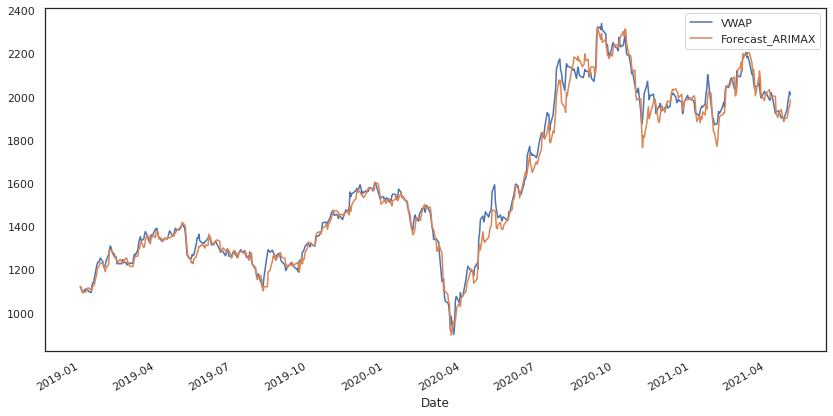

In [28]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

Facebook Prophet

In [29]:
from fbprophet import Prophet

model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



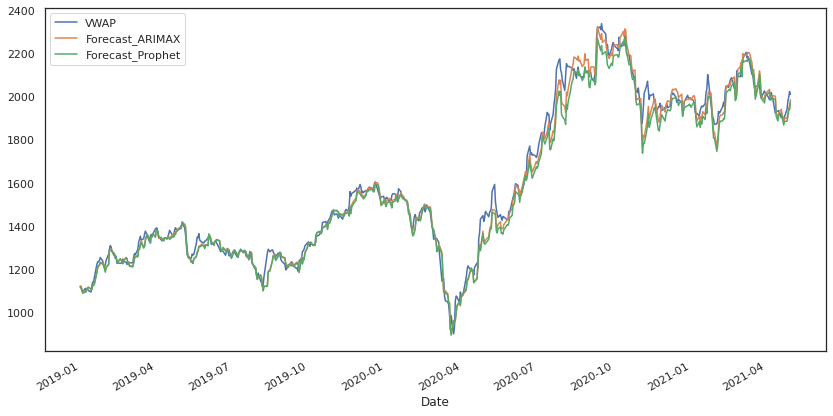

In [30]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [31]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 44.829698359608216
RMSE of Prophet: 56.14308311523716

MAE of Auto ARIMAX: 32.1611929285443
MAE of Prophet: 39.0446753094313


LIGHTGBM

In [32]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



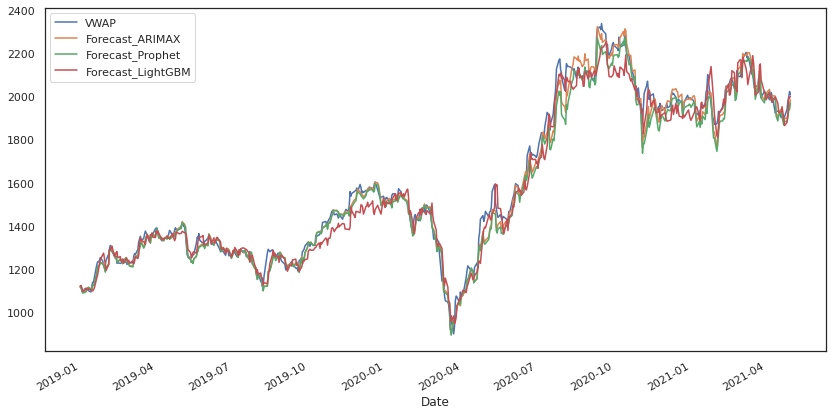

In [33]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [34]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

RMSE of Auto ARIMAX: 44.829698359608216
RMSE of Prophet: 56.14308311523716
RMSE of LightGBM: 58.565082643666294

MAE of Auto ARIMAX: 32.1611929285443
MAE of Prophet: 39.0446753094313
MAE of LightGBM: 44.28556274874711


In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [36]:
dataset = df[exogenous_features].values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [37]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [38]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [39]:
model = Sequential()
model.add(LSTM(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)

In [40]:
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

rmse:0.05911534528759391 MAE:0.03837550804018974


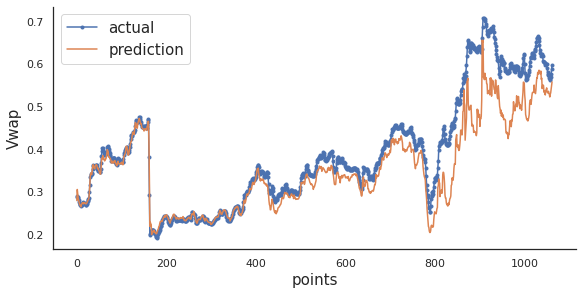

In [41]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();